# RBC with Tax (Coleman 1991)

Household: 
- $V(k,K,z) = \max_{c,k'} \{u(c)+βE[V(k',K',z')|z]\}$
- $u(c) = c^{(1-\sigma)}/(1-\sigma)$
- $c+k'=(1-\tau(K,z))(f(K,z)+(k-K)(f_1(K,z)+(1-\delta)k+d(K,z)=y(k,K,z)$
- $c,k' \in [0,y(k,K,z)]$
- $f(k,z) = zk^\alpha$
- $f_{1}(k,z) = z\alpha k^{\alpha-1}$
- $F(k,z) = zk^\alpha +(1-\delta)k$

Tax: 
- Tax Policy: $\tau(K,z)$ s.t. $(1-\tau(K,z))f_1(K,z)$ falling in $K$
- Transfer: $d(K,z) = \tau(K,z)$

Solution: 
- Find $k_{ss}$ from $1=\beta*(1-\tau(k_{ss},E[z])\alpha k_{ss}^{\alpha-1}+1-\delta)$ 
- Guess $c_{t}(k,z)$ in $[k_{ss}*0.9, k_{ss}*1.1]$x$Z$
- Define $H(k,z)=(1-\delta)+(1-\tau(k,z))f_{1}(k,z)$
- For each $k,z$, update $c_{t+1}(k,z)$ with $c$ that solves: $u'(c)-\beta E[u'(c_{t}(f(k,z)-c,z')) H(f(k,z)-c,z')|z]=0$ until convergence
- Store policy rules $c(k,z)$ and $k'(k,z) = f(k,z)+(1-\delta)k - c(k,z)$
- From initial $k_{0},z_{0}$ simulate economy with $k_{t+1}=k'(k_{t},z_{t})$ and $c_{t}=c(k_{t},z_{t})$

In [1]:
using LinearAlgebra, Statistics
using BenchmarkTools, Interpolations, LaTeXStrings, Parameters, Plots, QuantEcon, Roots
using Optim, Random
using BenchmarkTools, Interpolations, Parameters, Plots, QuantEcon, Roots
σ = 2.0;
β = 0.99;
α = 0.36;
δ = 0.025;
τ = 0;
Z = [0.99 1.01]
P = Array([0.9 0.1; 0.1 0.9])
up(c) = c^(-σ)
f(k,z) = z*k^α
F(k,z) = z*k^α+(1-δ)*k
fp(k,z) = z*α*k^(α-1)
H(k,z) = (1-τ)*fp(k,z)+(1-δ)
Kss = ((1/β+δ-1)/(α*(1-τ)))^(1/(α-1))
Css = Kss^α-δ*Kss
println((Kss,Css))
K = Array(range(Kss*0.8, Kss*1.2, 200))
    
function coleman!(Kg1, Kg2, g1, g2, K, β, up, f, fp)
    c1 = LinearInterpolation(K, g1, extrapolation_bc = Line()) # c(k,z1)
    c2 = LinearInterpolation(K, g2, extrapolation_bc = Line()) # c(k,z2)
    for (i,k) in enumerate(K)
        function h1(c) # Euler at k,z1
            kp = F(k,Z[1])-c 
            val1 = up.(c1.(kp)).* H(kp,Z[1]) #z'=z[1]
            val2 = up.(c2.(kp)).* H(kp,Z[2]) #z'=z[2]
            return up(c) - β*(P[1,1]*val1+P[1,2]*val2)
        end
        function h2(c) # Euler at k,z2
            kp = F(k,Z[2])-c 
            val1 = up.(c1.(kp)).* H(kp,Z[1]) #z'=z[1]
            val2 = up.(c2.(kp)).* H(kp,Z[2]) #z'=z[2]
            return up(c) - β*(P[2,1]*val1+P[2,2]*val2)
        end
        Kg1[i] = find_zero(h1, (1e-10, F(k,Z[1])-1e-10)) # Update c(k,z1)
        Kg2[i] = find_zero(h2, (1e-10, F(k,Z[2])-1e-10)) # Update c(k,z2)
    end
    return Kg1,Kg2
end
coleman(g1, g2, K, β, up, f, fp) = coleman!(similar(g1), similar(g2), g1, g2, K, β, up, f, fp)

function timeIteration(c1_init, c2_init)
    c1 = c1_init
    c2 = c2_init
    error=1
    while error>1e-6
        new_c1, new_c2 = coleman(c1, c2, K, β, up, f, fp)
        error = norm(c1-new_c1)+norm(c2-new_c2)
        c1 = new_c1
        c2 = new_c2        
    end
    return c1,c2
end
c1,c2 = timeIteration(1/13*K, 1/13*K)

(37.98925353815241, 2.7543274731365246)


([2.4818423474831706, 2.4846934640901397, 2.487541136997335, 2.490385379033597, 2.4932262029314405, 2.496063621327259, 2.4988976467615376, 2.5017282916788623, 2.5045555684284753, 2.507379489263952  …  2.973114330097657, 2.975480024119019, 2.977843820280807, 2.9802057238416233, 2.982565740021369, 2.9849238740021646, 2.987280130928537, 2.9896345159094104, 2.991987034018795, 2.9943376902962475], [2.489423566208654, 2.4922749533340456, 2.4951228926820157, 2.49796739701055, 2.5008084789750407, 2.5036461511268833, 2.5064804259128333, 2.5093113156759412, 2.5121388326516936, 2.5149629889689926  …  2.980716655526143, 2.983082415004495, 2.9854462776068145, 2.987808248518399, 2.990168332889217, 2.9925265358348203, 2.9948828624373123, 2.9972373177461384, 2.999589906778863, 3.0019406345219473])

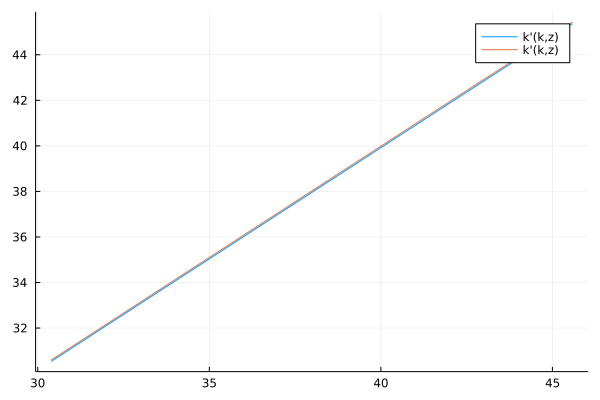

In [2]:
k1 = F.(K,Z[1]) - c1;
k2 = F.(K,Z[2]) - c2;
KP = hcat(k1,k2)
CP = hcat(c1,c2)
plot(K, KP, label="k'(k,z)")

In [6]:
KP

200×2 Matrix{Float64}:
 30.5337  30.5945
 30.6084  30.6692
 30.6831  30.744
 30.7577  30.8187
 30.8324  30.8934
 30.907   30.9681
 30.9817  31.0428
 31.0563  31.1175
 31.131   31.1922
 31.2056  31.2669
 31.2803  31.3417
 31.3549  31.4164
 31.4295  31.4911
  ⋮       
 44.5497  44.6207
 44.6242  44.6952
 44.6987  44.7697
 44.7731  44.8443
 44.8476  44.9188
 44.9221  44.9933
 44.9965  45.0678
 45.071   45.1423
 45.1455  45.2168
 45.2199  45.2914
 45.2944  45.3659
 45.3689  45.4404

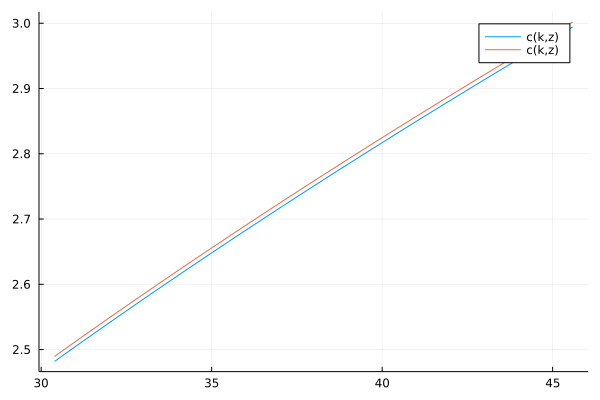

In [3]:
plot(K, CP, label="c(k,z)")

In [5]:
CP

200×2 Matrix{Float64}:
 2.48184  2.48942
 2.48469  2.49227
 2.48754  2.49512
 2.49039  2.49797
 2.49323  2.50081
 2.49606  2.50365
 2.4989   2.50648
 2.50173  2.50931
 2.50456  2.51214
 2.50738  2.51496
 2.5102   2.51778
 2.51302  2.5206
 2.51583  2.52342
 ⋮        
 2.96838  2.97598
 2.97075  2.97835
 2.97311  2.98072
 2.97548  2.98308
 2.97784  2.98545
 2.98021  2.98781
 2.98257  2.99017
 2.98492  2.99253
 2.98728  2.99488
 2.98963  2.99724
 2.99199  2.99959
 2.99434  3.00194

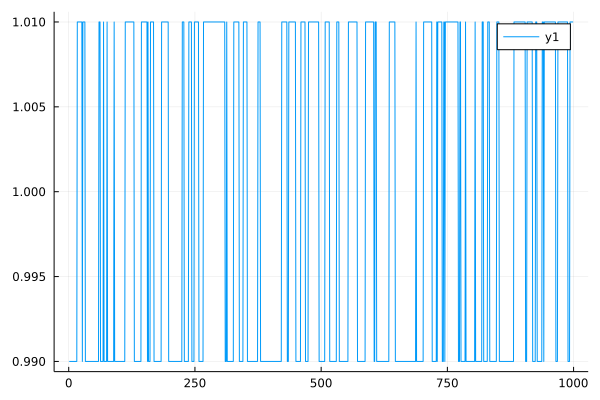

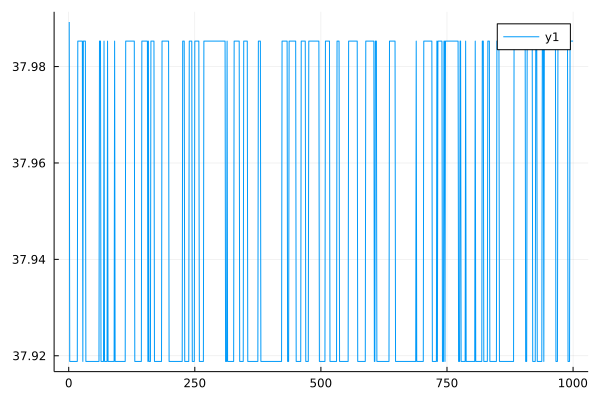

In [4]:
# Simulate
using QuantEcon
k0 = Kss
z0 = Z[1]
T = 1000
ZIND = simulate(MarkovChain(P), T);
KIND = simulate(MarkovChain(P), T);
KPATH = k0*Array(1:T)
ZPATH = z0*Array(1:T-1);
for i in 1:T-1
    z = ZIND[i]
    KIND[i] = partialsortperm(abs.(K .- KPATH[i]), 1)
    KPATH[i+1] = KP[KIND[i], z]
    ZPATH[i] = Z[z]
    #println((z, KIND[i], KPATH[i], KPATH[i+1], ZPATH[i]))
end
display(plot(ZPATH))
display(plot(KPATH))

In [7]:
model(Kss*0.9)

LoadError: UndefVarError: model not defined

In [11]:
K[1:50]

50-element Vector{Float64}:
 30.39140283052193
 30.467763139141333
 30.544123447760732
 30.620483756380136
 30.69684406499954
 30.77320437361894
 30.84956468223834
 30.92592499085774
 31.002285299477144
 31.078645608096547
 31.155005916715947
 31.23136622533535
 31.307726533954753
  ⋮
 33.293094558059195
 33.3694548666786
 33.445815175298
 33.5221754839174
 33.59853579253681
 33.67489610115621
 33.75125640977561
 33.827616718395014
 33.90397702701441
 33.98033733563381
 34.05669764425322
 34.13305795287262

In [12]:
Kss*0.9

34.19032818433717

In [14]:
CP[50]

2.6177150670201246